# Modelo de AI para Identificación de Carros - DL
Jorge de Jesús Castro Vázquez | A01707735

18/Mayo/2025

# Avances
- Data Set Seleccionado [Car Dataset](https://www.kaggle.com/code/kshitij192/car-images-classification-using-cnn/notebook)
- Uso de Data Augmentation para cumplir con regla 80/20
  - Aplicación de ```
shear_range, zoom_range, channel_shift_range, height_shift_range y width_shift_range```




### Selección de Dataset
Al inicio me encontré con dos tipos de Dataset que me llamaron la atención.

1. [Credit Approval](https://archive.ics.uci.edu/dataset/27/credit+approval)
2. [Default of Credit Card Clients](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

Estos Dataset, de la página de UCI Machine Learning Repository,  están descritos en un arhivo separado por comas (csv, por sus siglas en inglés) y cumplen con el criterio de ser de **"Clasificación"**.

Sin embargo, dentro de clase hemos usado Dataset de imagenes y me apegaré a ello para este proyecto. De este modo encontre otro Dataset con imágenes de carros en Kaggle, llamado [Car Images Classification using CNN](https://www.kaggle.com/code/kshitij192/car-images-classification-using-cnn/notebook).

La composición de éste es como se ve a contiuación:


```
Cars Dataset
├── test
│   ├── Audi (199 imágenes)
│   ├── Hyundai Creta (67 imágenes)
│   ├── Mahindra Scorpio (75 imágenes)
│   ├── Rolls Royce (74 imágenes)
│   ├── Swift (102 imágenes)
│   ├── Tata Safari (106 imágenes)
│   └── Toyota Innova (190 imágenes)
└── train
    ├── Audi (814 imágenes)
    ├── Hyundai Creta (271 imágenes)
    ├── Mahindra Scorpio (316 imágenes)
    ├── Rolls Royce (311 imágenes)
    ├── Swift (424 imágenes)
    ├── Tata Safari (441 imágenes)
    └── Toyota Innova (775 imágenes)
```


# CODIGO

### Cargar Dataset de Google Drive

In [1]:
from pickle import TRUE
from google.colab import drive
drive.mount('/content/drive',force_remount=TRUE)


Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/M2/Cars Dataset"
!ls

/content/drive/MyDrive/M2/Cars Dataset
test  train


### Imports

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, optimizers
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### Declaración de Path, tamaño de imageen y verificación

In [19]:

train_dir = os.path.join('train')
test_dir = os.path.join('test')
IMG_SIZE=128
!pwd

print(train_dir)
print(test_dir)

/content/drive/MyDrive/M2/Cars Dataset
train
test


In [31]:
# Este snippet fue hecho con Gemini AI para separar una cantidad de imagenes del TRAIN
# y usarlos como VAL del Modelo.
import shutil
import random

# Nombrar la carpeta Val
val_dir = 'val'

# Crear la carpeta en el path origen sí no existe
if not os.path.exists(val_dir):
  os.makedirs(val_dir)

# Leer la las classes que hay en el train
train_subdirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Indicar la cantidad de imagenes que se quieren para Val
num_images_per_class = 30

# Crear los directorios y
for subdir in train_subdirs:
  train_subdir_path = os.path.join(train_dir, subdir)
  val_subdir_path = os.path.join(val_dir, subdir)

  if not os.path.exists(val_subdir_path):
    os.makedirs(val_subdir_path)

  images = [f for f in os.listdir(train_subdir_path) if os.path.isfile(os.path.join(train_subdir_path, f))]

  # Seleccion random de 30 imagenes de cada subcarpeta
  selected_images = random.sample(images, min(num_images_per_class, len(images)))

  # Mover imagenes de train a val
  for image_name in selected_images:
    src_path = os.path.join(train_subdir_path, image_name)
    dest_path = os.path.join(val_subdir_path, image_name)
    shutil.move(src_path, dest_path)
    print(f"Moved {image_name} from {train_subdir_path} to {val_subdir_path}")

print("Validation dataset created successfully.")


Validation dataset created successfully.


### Data Augmentation y Generation
Apoyado de GenAI para separar las imagenes 80/20

In [ ]:
# Define the base paths for your datasets

# Define the target number of images for each split
target_train_images = 820
target_test_images = 200

# Data augmentation parameters
datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 10,
							width_shift_range = 0.1,
							height_shift_range = 0.1,
						  shear_range = 0.25,
							zoom_range = 0.3,
							horizontal_flip = True)

def augment_images_to_target(directory, target_count):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            current_count = len(images)
            print(f"Class: {class_name}, Current images: {current_count}, Target images: {target_count}")

            if current_count < target_count:
                needed_count = target_count - current_count
                print(f"Generating {needed_count} augmented images for {class_name}")

                # Determine how many augmented images to generate per original image
                # We want to generate needed_count in total, so distribute across existing images
                if current_count > 0:
                    aug_per_image = max(1, needed_count // current_count)
                else:
                    # If there are no original images, augmentation is not possible
                    print(f"No original images in {class_name} to augment.")
                    continue

                generated_count = 0
                for img_path in images:
                    if generated_count >= needed_count:
                        break # Stop if we have generated enough images

                    img = load_img(img_path)
                    x = img_to_array(img)
                    x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

                    # Generate augmented images
                    i = 0
                    for batch in datagen.flow(x, batch_size=1,
                                              save_to_dir=class_dir,
                                              save_prefix=f'dt_aug_{class_name}_',
                                              save_format='jpeg'):
                        i += 1
                        generated_count += 1
                        if i >= aug_per_image or generated_count >= needed_count:
                            break  # Generate a certain number of augmented images per original image

                print(f"Finished augmenting for {class_name}. Total images after augmentation: {len(os.listdir(class_dir))}")

# Augment the training data
print("Augmenting training data...")
augment_images_to_target(train_dir, target_train_images)

# Augment the test data
print("\nAugmenting test data...")
augment_images_to_target(test_dir, target_test_images)

print("\nData augmentation complete.")

Augmenting training data...
Class: Hyundai Creta, Current images: 800, Target images: 820
Generating 20 augmented images for Hyundai Creta
Finished augmenting for Hyundai Creta. Total images after augmentation: 818
Class: Audi, Current images: 820, Target images: 820
Class: Rolls Royce, Current images: 618, Target images: 820
Generating 202 augmented images for Rolls Royce
Finished augmenting for Rolls Royce. Total images after augmentation: 809
Class: Swift, Current images: 809, Target images: 820
Generating 11 augmented images for Swift
Finished augmenting for Swift. Total images after augmentation: 819
Class: Tata Safari, Current images: 817, Target images: 820
Generating 3 augmented images for Tata Safari
Finished augmenting for Tata Safari. Total images after augmentation: 820
Class: Toyota Innova, Current images: 820, Target images: 820
Class: Mahindra Scorpio, Current images: 629, Target images: 820
Generating 191 augmented images for Mahindra Scorpio
Finished augmenting for Mah

In [ ]:
from prettytable import PrettyTable

def count_files_in_folders(directory):
  """
  Counts the number of files in each subfolder of a given directory.

  Args:
    directory (str): The path to the directory to analyze.

  Returns:
    list: A list of dictionaries, where each dictionary contains the
          'Folder Name' and 'File Count' for a subfolder.
  """
  folder_data = []
  for root, dirs, files in os.walk(directory):
    file_count = len(files)
    folder_data.append({'Folder Name': os.path.relpath(root, directory), 'File Count': file_count})
  return folder_data

def print_file_count_table(directory):
  """
  Prints a table showing the file count for each subfolder.

  Args:
    directory (str): The path to the directory to analyze.
  """
  folder_data = count_files_in_folders(directory)

  table = PrettyTable()
  table.field_names = ["Folder Name", "File Count"]

  for data in folder_data:
    table.add_row([data['Folder Name'], data['File Count']])

  print(table)

# Example usage with your train and test directories:
print("File counts in train directory:")
print_file_count_table(train_dir)

print("\nFile counts in test directory:")
print_file_count_table(test_dir)

File counts in train directory:
+------------------+------------+
|   Folder Name    | File Count |
+------------------+------------+
|        .         |     0      |
|  Hyundai Creta   |    818     |
|       Audi       |    820     |
|   Rolls Royce    |    809     |
|      Swift       |    819     |
|   Tata Safari    |    820     |
|  Toyota Innova   |    820     |
| Mahindra Scorpio |    806     |
+------------------+------------+

File counts in test directory:
+------------------+------------+
|   Folder Name    | File Count |
+------------------+------------+
|        .         |     0      |
|  Toyota Innova   |    200     |
|   Tata Safari    |    200     |
|      Swift       |    200     |
| Mahindra Scorpio |    200     |
|       Audi       |    200     |
|   Rolls Royce    |    200     |
|  Hyundai Creta   |    200     |
+------------------+------------+


### Generación de Data de Entrenamiento
Se hace un reescalamiento, se aplica zoom, shear, horizontal flip y rotación

In [20]:
# Configuración del obejto ImageDataGenerator para aplicar augmentation
train_datagen = ImageDataGenerator(
							rescale = 1./255, # Reescalamiento de la imagen
							rotation_range = 10,
							width_shift_range = 0.1,
							height_shift_range = 0.1,
						  shear_range = 0.25,
							zoom_range = 0.3,
							horizontal_flip = True)

### Aplicar Data Augmentation

In [40]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (IMG_SIZE, IMG_SIZE),
							batch_size = 32,
							class_mode ='categorical',
							)
images, labels = train_generator[0]


Found 3142 images belonging to 7 classes.
(32, 128, 128, 3)
[0. 0. 0. 0. 0. 0. 1.]


<Figure size 640x480 with 0 Axes>

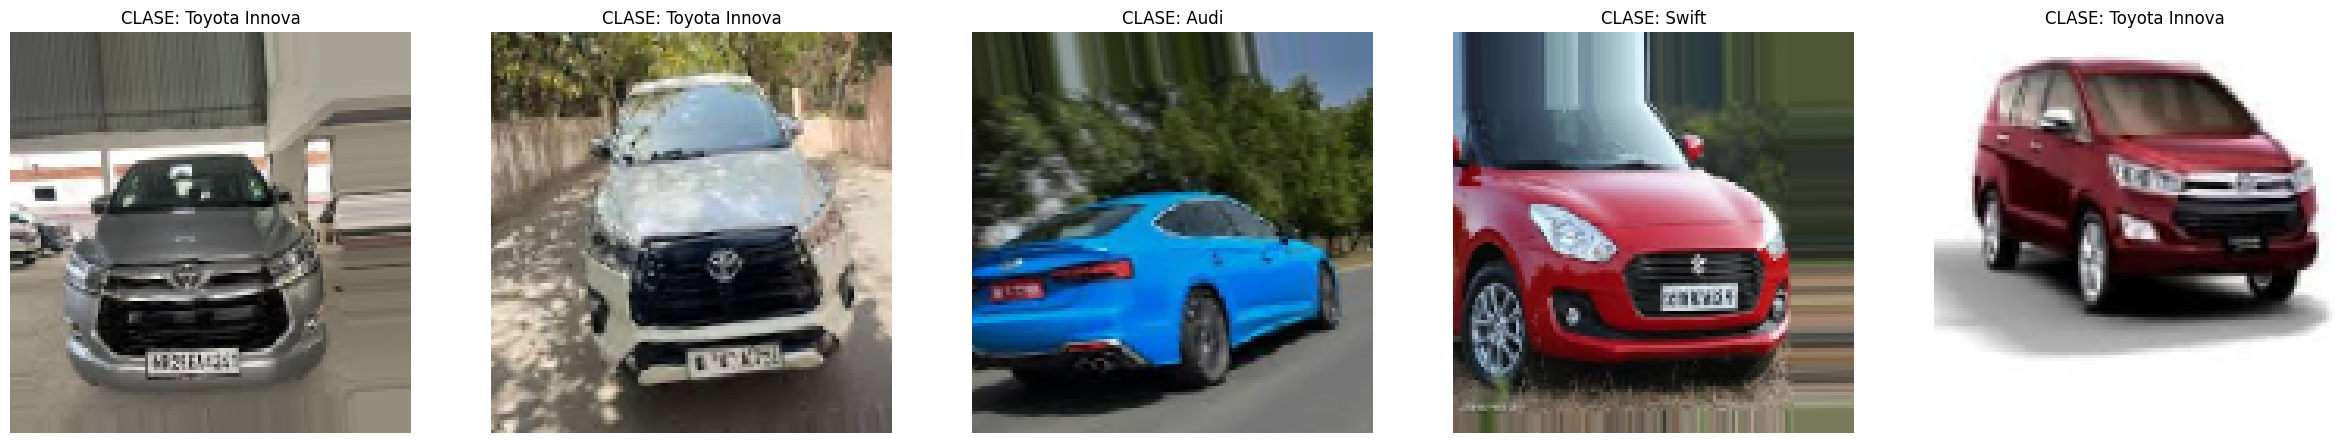

In [41]:
plt.figure()

f, axarr = plt.subplots(1, 5, figsize=(30, 8))
images, labels = train_generator[0]

# Mapa de Labels
label_map = {v: k for k, v in train_generator.class_indices.items()}

for i in range(5):
	axarr[i].imshow(images[i])
	class_index = tf.argmax(labels[i]).numpy()
	class_name = label_map[class_index]
	axarr[i].set_title(f"CLASE: {class_name}")
	axarr[i].axis('off')

In [52]:
train_image_rescale = ImageDataGenerator(rescale=1./255)
train_rescale_generator = train_image_rescale.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical'
)

val_image_rescale = ImageDataGenerator(rescale=1./255)
val_rescale_generator = val_image_rescale.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical'
)

test_image_rescale = ImageDataGenerator(rescale=1./255)
test_rescale_generator = test_image_rescale.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical'
)

Found 3142 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


# Construcción de la Red Neuronal

In [55]:

img_shape = (IMG_SIZE, IMG_SIZE, 3)
model = models.Sequential()

model.add(Conv2D(32, (3, 3),activation="relu", kernel_constraint=max_norm(3), input_shape=img_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3),activation="relu", kernel_constraint=max_norm(3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation="relu", kernel_constraint=max_norm(3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,407 (49.37 MB)

 Trainable params: 12,942,407 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiendo del Modelo sin usar GenData

In [66]:
history = model.fit(train_generator,epochs= 30, validation_data=val_rescale_generator)

model.save("my_model_no_datagen.keras")
model.save("my_model_no_datagen.h5")

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 263ms/step - accuracy: 0.2182 - loss: 2.1339 - val_accuracy: 0.2190 - val_loss: 2.0372
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.3191 - loss: 1.7731 - val_accuracy: 0.2381 - val_loss: 1.8921
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.3371 - loss: 1.7399 - val_accuracy: 0.2571 - val_loss: 1.9219
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.3952 - loss: 1.6478 - val_accuracy: 0.2952 - val_loss: 1.7942
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.4191 - loss: 1.5658 - val_accuracy: 0.3143 - val_loss: 1.7023
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.4386 - loss: 1.5270 - val_accuracy: 0.3048 - val_loss: 1.7728
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.4648 - loss: 1.4527 - val_accuracy: 0.3952 - val_loss: 1.6161
Epoch 8/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.5157 - loss: 1.3666 - val_accu

### Evaluación del Modelo con Test

In [68]:
test_loss, test_accuracy = model.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_accuracy}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7666 - loss: 0.6996
Test accuracy: 0.7662976384162903


### Evaluación del Modelo Base (Sin usar DataGen)

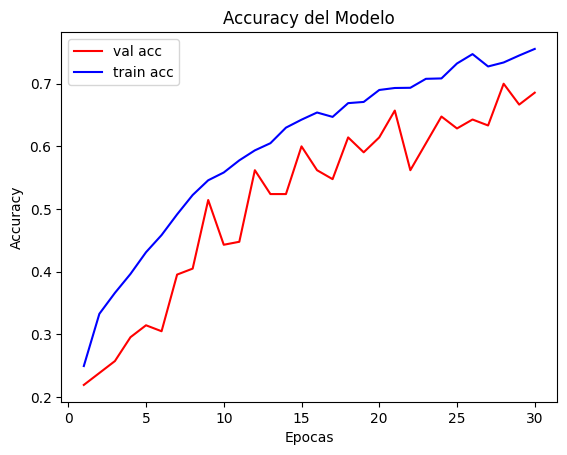

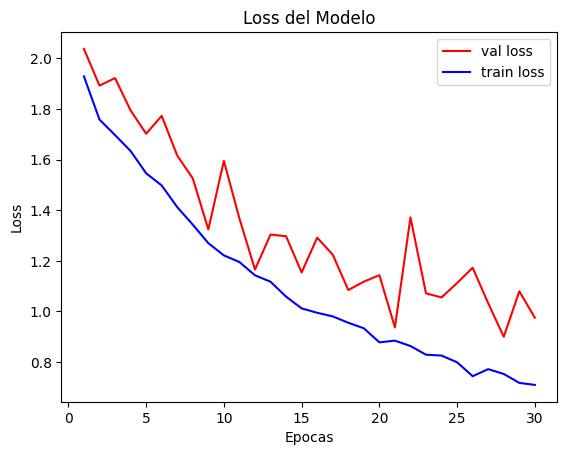

In [69]:
# Declarar los valores a gráficar: Train y Val. Test se evaluó anterioremente
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

num_epochs = range(1, len(train_accuracy) + 1)

# Graficar Accuracy del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_accuracy, 'r', label='val acc')
plt.plot(num_epochs, train_accuracy, 'b', label='train acc')
# plt.plot(num_epochs, test_accuracy, 'g', label='test acc')

# Configuración de Labels y Titulo de la gráfica
plt.title('Accuracy del Modelo')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

# Graficar Loss del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_loss, 'r', label='val loss')
plt.plot(num_epochs, train_loss, 'b', label='train loss')
# plt.plot(num_epochs, train_loss, 'g', label='test loss')

# Configuración de Labels y título de gráfico
plt.title('Loss del Modelo')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

plt.show()